In [ ]:
!pip install d2l

In [2]:
import tensorflow as tf
import d2l.tensorflow as d2l

In [3]:
import math
import collections

In [4]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(Encoder, self).__init__(**kwargs)
  def call(self, X, *args, **kwargs):
    raise NotImplementedError

In [5]:
class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
    super().__init__(*kwargs)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size)
    self.rnn = tf.keras.layers.RNN(
        tf.keras.layers.StackedRNNCells([
          tf.keras.layers.GRUCell(units=num_hiddens, dropout=dropout)
          for _ in range(num_layers)
        ]), return_sequences=True, return_state=True
    )
  
  def call(self, X, *args, **kwargs):
    X = self.embedding(X)
    output = self.rnn(X, **kwargs)
    state = output[1:]
    return output[0], state

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X, training=False)
output.shape

TensorShape([4, 7, 16])

In [7]:
class Seq2SeqDecoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
    super().__init__(**kwargs)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size)
    self.rnn = tf.keras.layers.RNN(
        tf.keras.layers.StackedRNNCells([
          tf.keras.layers.GRUCell(units=num_hiddens, dropout=dropout)
          for _ in range(num_layers)
        ]), return_sequences=True, return_state=True
    )
    self.dense = tf.keras.layers.Dense(units=vocab_size)
  
  def init_state(self, enc_outputs, *args):
    return enc_outputs[1]
  
  def call(self, X, state, **kwargs):
    X = self.embedding(X)
    context = tf.repeat(tf.expand_dims(state[-1], axis=1), repeats=X.shape[1], axis=1)
    X_and_context = tf.concat((X, context), axis=2)
    rnn_output = self.rnn(X_and_context, state, **kwargs)
    output = self.dense(rnn_output[0])
    return output, rnn_output[1:]

In [8]:
decoder = Seq2SeqDecoder(10, 8, 16, 2)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state, training = False)
output.shape, len(state), state[0].shape

(TensorShape([4, 7, 10]), 2, TensorShape([4, 16]))

In [9]:
def sequence_mask(X, valid_len, value=0):
  maxlen = X.shape[1]
  mask = tf.range(
      start=0, limit=maxlen, dtype=tf.float32
      )[None,:] < tf.cast(valid_len[:,None],dtype=tf.float32)
  if len(X.shape)==3:
    return tf.where(tf.expand_dims(mask, axis=-1), X, value)
  else:
    return tf.where(mask, X, value)

X = tf.constant([[1,2,3],[4,5,6]])
sequence_mask(X, tf.constant([1,2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [10]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
  def __init__(self, valid_len):
    super().__init__(reduction='none')
    self.valid_len=valid_len
  
  def call(self, label, pred):
    weights = tf.ones_like(label, dtype=tf.float32)
    weights = sequence_mask(weights, self.valid_len)
    label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
    unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction='none'
    )(label_one_hot, pred)
    weighted_loss = tf.reduce_mean((unweighted_loss * weights), axis=1)
    return weighted_loss

In [11]:
loss = MaskedSoftmaxCELoss(tf.constant([4,2,0]))
loss(tf.ones((3,4),dtype=tf.int32) , tf.ones((3,4,10))).numpy()

array([2.3025851, 1.1512926, 0.       ], dtype=float32)

In [14]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  animator = d2l.Animator(xlabel="epoch", ylabel='loss', xlim=[10, num_epochs])
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    for batch in data_iter:
      X, X_valid_len, Y, Y_valid_len = [x for x in batch]
      bos = tf.reshape(tf.constant([tgt_vocab['<bos>']]*Y.shape[0]), shape=(-1,1))
      dec_input = tf.concat([bos, Y[:, :-1]], 1)
      with tf.GradientTape() as tape:
        Y_hat, _ = net(X, dec_input, X_valid_len, training=True)
        l = MaskedSoftmaxCELoss(Y_valid_len)(Y,Y_hat)
      gradients = tape.gradient( l, net.trainable_variables )
      gradients = d2l.grad_clipping(gradients, 1)
      optimizer.apply_gradients(zip(gradients, net.trainable_variables))
      num_tokens = tf.reduce_sum(Y_valid_len).numpy()
      metric.add(tf.reduce_sum(l), num_tokens)
    if (epoch+1)%10==0:
      animator.add(epoch+1, (metric[0]/metric[1], ))
  print(f'loss {metric[0]/metric[1]:.3f}, {metric[1]/timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.024, 1129.1 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f3470c1c8c0>


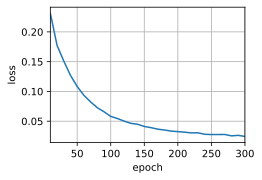

In [15]:
embed_size = 32
num_hiddens = 32
num_layers = 2
dropout = 0.1
batch_size = 64
num_steps = 10
lr = 0.005
num_epochs = 300
device = d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [16]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
  src_tokens = src_vocab[src_sentence.lower().split(' ')]+[src_vocab['<eos>']]
  enc_valid_len = tf.constant([len(src_tokens)])
  src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
  enc_X = tf.expand_dims(src_tokens, axis=0)
  enc_outputs = net.encoder(enc_X, enc_valid_len, training=False)
  dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
  dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
  output_seq, attention_weight_seq = [],[]
  for _ in range(num_steps):
    Y, dec_state = net.decoder(dec_X, dec_state, training=False)
    dec_X = tf.argmax(Y, axis=2)
    pred = tf.squeeze(dec_X, axis=0)
    if save_attention_weights:
      attention_weight_seq.append(net.decoder.attention_weights)
    if pred==tgt_vocab['<eos>']:
      break
    output_seq.append(pred.numpy())
  return ' '.join(
      tgt_vocab.to_tokens(
          tf.reshape(
              output_seq, shape=-1
          ).numpy().tolist()
      )
  ), attention_weight_seq

In [19]:
def bleu(pred_seq, label_seq, k):
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
  len_pred = len(pred_tokens)
  len_label = len(label_tokens)
  score = math.exp(min(0, 1-len_label/len_pred))
  for n in range(1, k+1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
      label_subs[''.join(label_tokens[i:i+n])]+=1
    for i in range(len_pred-n+1):
      if label_subs[''.join(pred_tokens[i:i+n])]>0:
        num_matches+=1
        label_subs[''.join(pred_tokens[i:i+n])] -= 1
    score *= math.pow(num_matches/(len_pred-n+1), math.pow(0.5, n))
  return score

In [20]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moid .']
for eng, fra in zip(engs, fras):
  translation, attention_weight_seq = predict_seq2seq(
      net, eng, src_vocab, tgt_vocab, num_steps
  )
  print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.658
i'm home . => je suis chez moi qui ai triste ., bleu 0.517
